In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

# PLOTTING
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
import math

# PYTORCH 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms, utils

import torch.optim as optim
import torch.nn as nn

from models import Net

In [3]:
from datasetFromFile import MidiSavedDataset
midi_train_dataset = MidiSavedDataset(data_type = "train")
midi_val_dataset   = MidiSavedDataset(data_type = "val")
midi_test_dataset  = MidiSavedDataset(data_type = "test")

In [4]:
len(midi_train_dataset)

100000

In [5]:
trainloader = DataLoader(midi_train_dataset, batch_size=256,
                        shuffle=True, num_workers=6)
valloader   = DataLoader(midi_val_dataset, batch_size=256,
                        shuffle=True, num_workers=6)
testloader  = DataLoader(midi_test_dataset, batch_size=256,
                        shuffle=True, num_workers=6)

In [6]:
def evaluate_metrics(preds, labels): 
    correct = 0.0
    total = 0.0

    num_timesteps = labels.shape[0]

    for i in range(num_timesteps): 
        if (labels[i] == preds[i]):
            correct += 1.0
        total += 1.0
            
    accuracy = correct/total 

    return accuracy

In [7]:
sigmoid = torch.nn.Sigmoid()

### Train Network

In [8]:
num_notes = 129

# Preds
val_preds_list  = []
test_preds_list = []

# Labels 
val_labels_list = []
test_labels_list = []

# Loss 
train_loss_list = []
val_loss_list   = []
test_loss_list = []

net = Net().cuda().double()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

for epoch in range(30):  # loop over the dataset multiple times

    # TRAIN 
    train_labels = np.zeros((len(trainloader.dataset), 1))
    train_preds  = np.zeros((len(trainloader.dataset), num_notes))
    idx = 0
    for i, data in enumerate(trainloader, 0):
  
        inputs, labels = data
        train_labels[idx:idx+labels.shape[0], :] = labels

        inputs = inputs.cuda()
        labels = labels.cuda()

        labels = labels.squeeze(1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.double())

        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        train_preds[idx:idx+labels.shape[0], :]  = sigmoid(outputs.cpu().detach()).numpy()

        idx = idx + labels.shape[0]
#         print("Iter: ", i, ", Loss: ", loss.item())

        if (i % 1000 == 0): 
            print("Iter: ", i, ", Loss: ", loss.item())

        # Get loss 
        train_loss_list.append(loss.item())
        
        

    # VALIDATE
    sum_val_loss = 0
    val_labels = np.zeros((len(valloader.dataset), 1))
    val_preds  = np.zeros((len(valloader.dataset), 1))
    idx = 0
    with torch.no_grad():
        for i, data in enumerate(valloader,0):
            inputs, labels = data
            val_labels[idx:idx+labels.shape[0], :] = labels.cpu().detach().numpy()
            inputs = inputs.cuda()
            labels = labels.cuda()
            labels = labels.squeeze(1)
            
            outputs = net(inputs.double())

            loss = criterion(outputs, labels.long())
            
#             val_preds[idx:idx+labels.shape[0], :]  = sigmoid(outputs.cpu().detach()).numpy()
            val_preds[idx:idx+labels.shape[0], :] = np.expand_dims(np.argmax(outputs.cpu().detach().numpy(), axis = 1), axis = 1)

            val_labels_list.append(val_labels)
            val_preds_list.append(val_preds)
            
            idx = idx + labels.shape[0]
        
            
    val_loss_list.append(loss.item())


    #TEST
#         sum_test_loss = 0
#         test_labels = np.zeros((len(testloader.dataset), 1))
#         test_preds  = np.zeros((len(testloader.dataset), num_notes))
#         with torch.no_grad():
#             for i, data in enumerate(testloader,0):
#                 inputs, labels = data
#                 test_labels[idx:idx+labels.shape[0], :] = labels.cpu().detach().numpy()

#                 inputs = inputs.cuda()
#                 labels = labels.cuda()
#                 labels = labels.squeeze(1)
#                 outputs = net(inputs.double())

#                 loss = criterion(outputs, labels.long())

#                 sum_test_loss += loss.item()

#                 test_preds[idx:idx+labels.shape[0], :]  = sigmoid(outputs.cpu().detach()).numpy()

#                 test_labels_list.append(test_labels)
#                 test_preds_list.append(test_preds)
#         # Loss 
#         avg_test_loss = sum_test_loss / len(testloader)
#         test_loss_list.append(avg_test_loss)

    
    print("Epoch: ", epoch)

print('Finished Training')

Iter:  0 , Loss:  4.862790463147602
Epoch:  0
Iter:  0 , Loss:  1.6743455853486393
Epoch:  1
Iter:  0 , Loss:  1.1833108344283225
Epoch:  2
Iter:  0 , Loss:  1.1988948224258722
Epoch:  3
Iter:  0 , Loss:  1.1077794281690985
Epoch:  4
Iter:  0 , Loss:  1.0363901385018714
Epoch:  5
Iter:  0 , Loss:  1.043675380335519
Epoch:  6
Iter:  0 , Loss:  1.02448007609316
Epoch:  7
Iter:  0 , Loss:  0.9489773264796182
Epoch:  8
Iter:  0 , Loss:  1.025958502634485
Epoch:  9
Iter:  0 , Loss:  0.8721693837597448
Epoch:  10
Iter:  0 , Loss:  0.8154132124948673
Epoch:  11
Iter:  0 , Loss:  0.9815532545173772
Epoch:  12
Iter:  0 , Loss:  0.8709692518977339
Epoch:  13
Iter:  0 , Loss:  0.9588923781325529
Epoch:  14
Iter:  0 , Loss:  0.7937766233441361
Epoch:  15
Iter:  0 , Loss:  0.8326722345532629
Epoch:  16
Iter:  0 , Loss:  0.8261614387299153
Epoch:  17
Iter:  0 , Loss:  0.9407183131272104
Epoch:  18
Iter:  0 , Loss:  0.7255860669429671
Epoch:  19
Iter:  0 , Loss:  0.7547680838988534
Epoch:  20
Iter:  

In [9]:
PATH = './midi_net.pth'
torch.save(net.state_dict(), PATH)

In [9]:
val_preds_array = np.vstack(val_preds_list)
val_labels_array = np.vstack(val_labels_list)

In [13]:
print(len(train_loss_list))
print(len(val_loss_list))

590
5


### Evaluate metrics

In [12]:
accuracy = evaluate_metrics(val_preds_array, val_labels_array)
print(accuracy)

0.24314666666666668


In [14]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

all_zeros = np.zeros_like(val_preds_array)
all_zeros.fill(128)
accuracy_baseline = evaluate_metrics(all_zeros, val_labels_array)
print(accuracy_baseline)

0.19946666666666665


In [11]:
num_epochs = 30
val_scatter_time = np.arange(0,len(train_loss_list), (len(train_loss_list)/num_epochs))

In [23]:
print(val_scatter_time)

[  0. 118. 236. 354. 472.]


### Loss

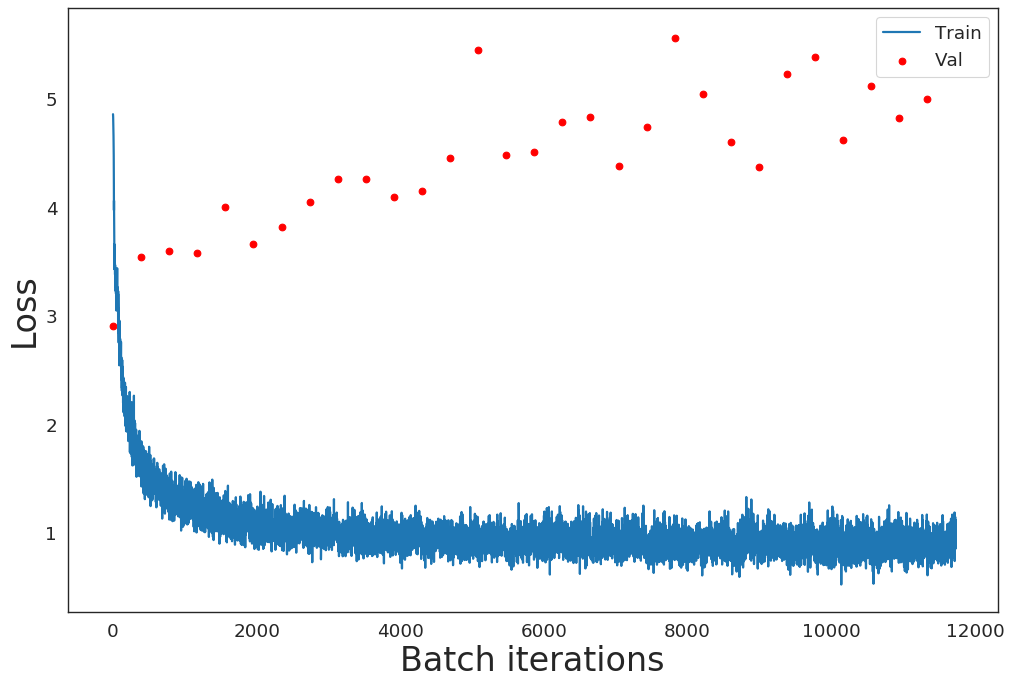

In [12]:
fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel('Batch iterations', fontsize=30)
plt.ylabel('Loss', fontsize=30)

plt.plot(train_loss_list, label='Train', linewidth=2)
# plt.plot(val_loss_list,   label='Val', linewidth=2)
plt.scatter(val_scatter_time, val_loss_list, c='red', label='Val')

plt.legend()
plt.show()

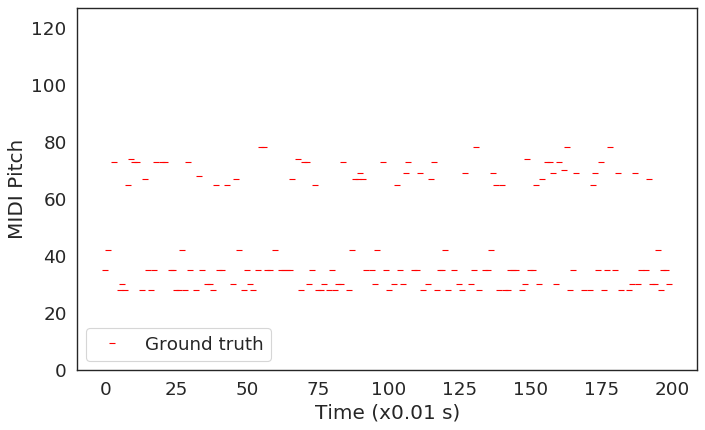

In [22]:

# output_X_val = np.argwhere(X_val>0)

# output_Y_val = np.argwhere(val_preds_array>0)



fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.scatter(output_Y_train[:,0], output_Y_train[:,1], marker='_', label='Ground truth')
# plt.plot(val_preds_array[30000:30100], '_', color='blue', label='Predictions')
plt.plot(val_labels_array[30000:30200], '_', color='red', label='Ground truth')
# plt.scatter(val_labels_array[30000:/31000])
plt.xlabel('Time (x0.01 s)')
plt.ylabel('MIDI Pitch')
plt.ylim(top=127)
plt.ylim(bottom=0)
plt.legend(loc='lower left')
plt.show()


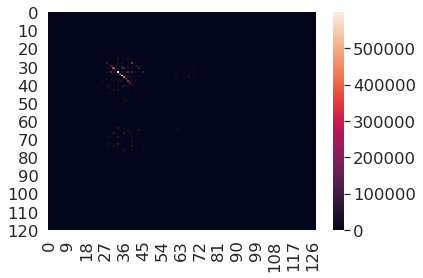

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sn 

cm = confusion_matrix(val_labels_array, val_preds_array, labels=np.arange(128))

sn.heatmap(cm)

In [14]:
all_zeros = np.zeros_like(val_preds_array)

all_zeros.fill(128)

In [15]:
from sklearn.metrics import classification_report 

print(classification_report(val_labels_array, all_zeros))

              precision    recall  f1-score   support

        23.0       0.00      0.00      0.00      4410
        24.0       0.00      0.00      0.00     36750
        25.0       0.00      0.00      0.00      1470
        26.0       0.00      0.00      0.00    282240
        27.0       0.00      0.00      0.00     39690
        28.0       0.00      0.00      0.00    614460
        29.0       0.00      0.00      0.00    307230
        30.0       0.00      0.00      0.00    582120
        31.0       0.00      0.00      0.00   1641990
        32.0       0.00      0.00      0.00    188160
        33.0       0.00      0.00      0.00   1874250
        34.0       0.00      0.00      0.00    693840
        35.0       0.00      0.00      0.00   1236270
        36.0       0.00      0.00      0.00   1146600
        37.0       0.00      0.00      0.00    463050
        38.0       0.00      0.00      0.00    649740
        39.0       0.00      0.00      0.00    373380
        40.0       0.00    